ADALINEをロジスティック回帰に変換

In [32]:
import numpy as np


class LogisticRegressionGD(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta  # 学習率 : float
        self.n_iter = n_iter  # 訓練回数 : int
        self.random_state = random_state  # 重みの初期化用の乱数

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    @staticmethod
    def activation(z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)

    # X: 訓練データセット
    # y: 目的変数
    def fit(self, X, y):
        gen = np.random.RandomState(self.random_state)
        self.w_ = gen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])  # 重み配列
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)

            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()

            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self

In [33]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(X[y == cl, 0], X[y == cl, 1], c=colors[idx], edgecolor='black',
                    alpha=0.8, marker=markers[idx], label=cl)
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], edgecolors='black',
                    alpha=1.0, linewidths=1, marker='o', s=100, label='test set')


Iris data set で確認

<ipython-input-33-39660de35be8>:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[y == cl, 0], X[y == cl, 1], c=colors[idx], edgecolor='black',


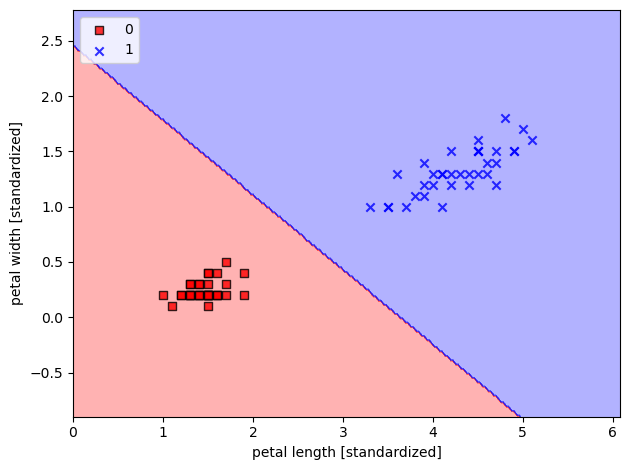

In [34]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, y=y_train_01_subset, classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

scikit-learn で実装

One vs Rest

<ipython-input-33-39660de35be8>:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[y == cl, 0], X[y == cl, 1], c=colors[idx], edgecolor='black',


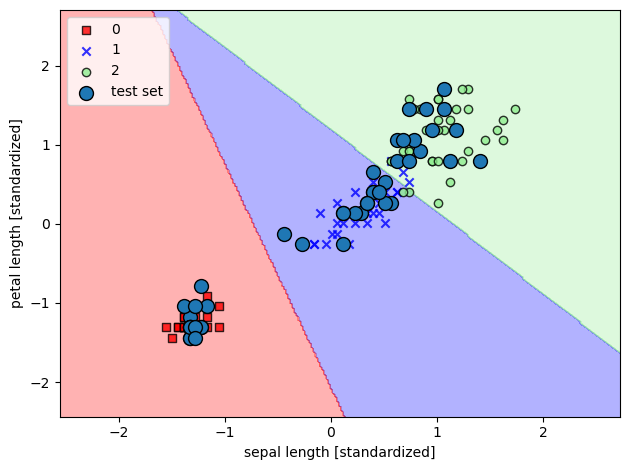

In [35]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined_std, y_combined, classifier=lr,
                      test_idx=range(105, 150))

plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

多項式でやってみる

<ipython-input-33-39660de35be8>:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[y == cl, 0], X[y == cl, 1], c=colors[idx], edgecolor='black',


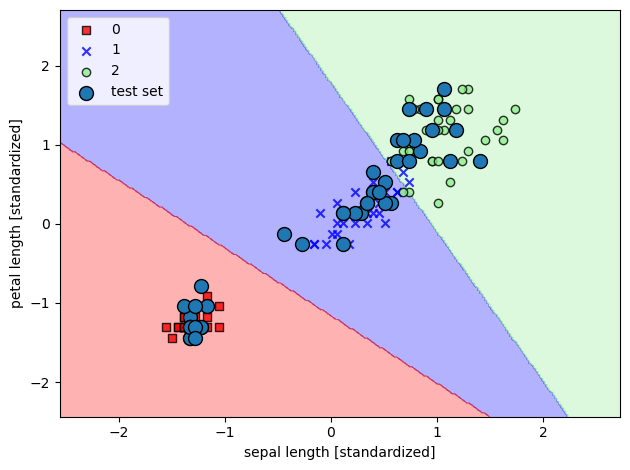

In [36]:
lr2 = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='multinomial')
lr2.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=lr2,
                      test_idx=range(105, 150))

plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

予測を適用

In [37]:
lr.predict_proba(X_test_std[:3, :])

array([[3.81527885e-09, 1.44792866e-01, 8.55207131e-01],
       [8.34020679e-01, 1.65979321e-01, 3.25737138e-13],
       [8.48831425e-01, 1.51168575e-01, 2.62277619e-14]])

In [38]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In [39]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [40]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])